In [ ]:
# Data Cleaning Notebook

'''
This notebook will outline and be used to clean the collected datasets (Income Distribution, Expenditure by Income Quantile, & US Waste Data). 
If a manipulation is done directly in Excel, there will be a cell explaining all steps & functions performed. For the sake of continuity I will 
attempt to perform all data-based operations within the bounds of this notebook. 
    
**All code is written by a GenAI Extension & I, unless otherwise specified**
'''

In [7]:
# ------------------------------------------------------------
# Income Distribution Data: Cleaning and Harmonization
# ------------------------------------------------------------
# This script ingests multiple ACS income profile tables,
# extracts a consistent set of income categories, and attempts 
# to produce a dataset suitable for incidence and analysis!
# ------------------------------------------------------------

import pandas as pd
import glob
import os

# Directory containing raw ACS income profile CSV files
data_dir = os.path.expanduser("~/Desktop/DESCO Case/Income Data/")
files = glob.glob(os.path.join(data_dir, "*.csv"))

# Income categories retained for analysis.
# These bins define the household income distribution
keep_rows = [
    "Total households",
    "Less than $10,000",
    "$10,000 to $14,999",
    "$15,000 to $24,999",
    "$25,000 to $34,999",
    "$35,000 to $49,999",
    "$50,000 to $74,999",
    "$75,000 to $99,999",
    "$100,000 to $149,999",
    "$150,000 to $199,999",
    "$200,000 or more",
    "Median household income (dollars)",
    "Mean household income (dollars)"
]

# Normalize target labels
keep_set = {
    s.replace("\u00a0", " ").strip()
    for s in keep_rows
}

dfs = []

for f in files:
    # Read
    df = pd.read_csv(f)

    # Income category labels
    label_col = df.columns[0]

    # Standardize labels
    labels = (
        df[label_col]
        .astype(str)
        .str.replace("\u00a0", " ", regex=False)  # remove non-breaking spaces
        .str.strip()                             
    )

    # Retain only the income categories relevant
    mask = labels.isin(keep_set)
    out = df.loc[mask].copy()
    out[label_col] = labels[mask]

    # Record source file to allow YoY analysis
    out["source_file"] = os.path.basename(f)

    dfs.append(out)

# Concatenate all years into a single df
cleaned = pd.concat(dfs, ignore_index=True)
output_path = os.path.join(data_dir, "Cleaned_Year.csv")
cleaned.to_csv(output_path, index=False)

# Check
print(f"Kept {len(keep_set)} target income categories.")
print("Row counts per source file:")
print(cleaned["source_file"].value_counts())

Kept 13 target income categories.
Row counts per source file:
source_file
ACSDP5Y2020.DP03-2026-01-19T214013.csv    23
ACSDP5Y2022.DP03-2026-01-19T214052.csv    23
ACSDP5Y2021.DP03-2026-01-19T214035.csv    23
ACSDP5Y2018.DP03-2026-01-19T213758.csv    23
ACSDP5Y2019.DP03-2026-01-19T213941.csv    23
ACSDP5Y2023.DP03-2026-01-19T214106.csv    23
Name: count, dtype: int64


In [8]:
# ------------------------------------------------------------
# Income Distribution Data: Re-Formatting
# ------------------------------------------------------------
import re

# ---- helpers ----
def extract_year_from_source_file(s: str) -> str:
    m = re.search(r"ACSDP5Y(\d{4})", str(s))
    if not m:
        raise ValueError(f"Could not parse year from source_file: {s}")
    return m.group(1)

def canonical_measure_name(col: str) -> str:
    """
    Normalize ACS column names into stable suffixes.
    Adjust mappings if your raw column headers differ.
    """
    c = str(col).strip()

    mappings = {
        "Estimate": "Estimate",
        "Margin of Error": "Est_Margin_of_Error",
        "Percent": "Percent",
        "Percent Margin of Error": "Pct_Margin_of_Error",
        "Percent margin of error": "Pct_Margin_of_Error",
    }
    if c in mappings:
        return mappings[c]

    # fallback: sanitize column name
    c = c.replace("\u00a0", " ").strip()
    c = c.replace("%", "Pct")
    c = re.sub(r"[^\w]+", "_", c)
    c = re.sub(r"_+", "_", c).strip("_")
    return c

# ---- main reshape ----
label_col = cleaned.columns[0]  # first column is the row label

# Add year parsed from source_file
cleaned = cleaned.copy()
cleaned["year"] = cleaned["source_file"].apply(extract_year_from_source_file)

# Identify the "measure" columns to pivot
exclude_cols = {label_col, "source_file", "year"}
value_cols = [c for c in cleaned.columns if c not in exclude_cols]

# Long format: (income_label, year, measure, value)
long_df = cleaned.melt(
    id_vars=[label_col, "year"],
    value_vars=value_cols,
    var_name="measure",
    value_name="value"
)

# Naming
long_df["year_measure"] = long_df.apply(
    lambda r: f"{r['year']}_{canonical_measure_name(r['measure'])}",
    axis=1
)

# Wide pivot
wide = (
    long_df
    .pivot_table(index=label_col, columns="year_measure", values="value", aggfunc="first")
    .reset_index()
)

cols = [label_col] + sorted([c for c in wide.columns if c != label_col])
wide = wide[cols]

# Save
output_path = os.path.join(data_dir, "Cleaned_Year_Wide.csv")
wide.to_csv(output_path, index=False)

print(f"Saved reshaped file")
print("Sample columns:", wide.columns[:12].tolist())


Saved reshaped file to: /Users/mikedirksen/Desktop/DESCO Case/Income Data/Cleaned_Year_Wide.csv
Sample columns: ['Label (Grouping)', '2018_United_States_Estimate', '2018_United_States_Margin_of_Error', '2018_United_States_Percent', '2018_United_States_Percent_Margin_of_Error', '2019_United_States_Estimate', '2019_United_States_Margin_of_Error', '2019_United_States_Percent', '2019_United_States_Percent_Margin_of_Error', '2020_United_States_Estimate', '2020_United_States_Margin_of_Error', '2020_United_States_Percent']


In [17]:
# ------------------------------------------------------------
# Expenditure-by-Income Cleaning (2018–2023) -> Wide CSV Output
# ------------------------------------------------------------
# Goal:
# For each year-specific Excel file, extract the "Average annual expenditures"
# (Mean) row by income category, then assemble a single dataset with:
# ------------------------------------------------------------

import os
import re
import glob
import pandas as pd
from zipfile import BadZipFile
from openpyxl import load_workbook

# -----------------------------
# CONFIG
# -----------------------------
data_dir = os.path.expanduser("~/Desktop/DESCO Case/Expenditure by Income/")
output_path = os.path.join(data_dir, "Expenditure_By_Income_2018_2023.csv")

# Collect .xlsx files
files = sorted(glob.glob(os.path.join(data_dir, "*.xlsx")))

# Filter - WRITTEN BY CLAUDE.AI
files = [
    f for f in files
    if not os.path.basename(f).startswith(("._", "~$")) # Folder var filtering
]

print(f"Found {len(files)} usable Excel files")
for f in files:
    print("  ", os.path.basename(f))

if len(files) == 0:
    raise FileNotFoundError(
        "No usable .xlsx files found. Check the path, file extensions, "
        "or whether files are stored in a subfolder."
    )

# -----------------------------
# HELPERS
# -----------------------------
def extract_year_from_filename(fname: str) -> str:
    """
    Extract a 4-digit year from filenames like:
      cu-income-before-taxes-2018.xlsx -> 2018
    """
    m = re.search(r"(19|20)\d{2}", fname)
    if not m:
        raise ValueError(f"Could not parse year from filename: {fname}")
    return m.group(0)

def normalize(x) -> str:
    """Normalize text cells (remove non-breaking spaces, line breaks, trim)."""
    if x is None:
        return ""
    return str(x).replace("\n", " ").replace("\u00a0", " ").strip()

def find_header_row(ws, needle="Item", search_rows=60):
    """
    Identify the header row by locating the 'Item' label in column A.
    (BLS tables typically label the left-most column as 'Item'.)
    """
    for r in range(1, min(search_rows, ws.max_row) + 1):
        if normalize(ws.cell(r, 1).value).lower() == needle.lower():
            return r
    return None

def find_mean_row_for_avg_annual_expend(ws):
    """
    Locate the 'Average annual expenditures' section (col A), then
    return the row index for the 'Mean' entry within that block.
    """
    for r in range(1, ws.max_row + 1):
        if "average annual expenditures" in normalize(ws.cell(r, 1).value).lower():
            # Search a short window beneath for the 'Mean' row
            for rr in range(r + 1, min(r + 20, ws.max_row) + 1):
                if normalize(ws.cell(rr, 1).value).lower() == "mean":
                    return rr
            return None
    return None

# -----------------------------
# EXTRACT YEARLY SERIES
# -----------------------------
all_year_series = []

for f in files:
    base = os.path.basename(f)
    year = extract_year_from_filename(base)

    # Open workbook safely
    try:
        wb = load_workbook(f, data_only=True)
    except BadZipFile:
        print(f"Not a valid .xlsx: {base}")
        continue
    except Exception as e:
        print(f"Could not open workbook {base}: {type(e).__name__}: {e}")
        continue

    extracted = False

    # Search all sheets
    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]

        header_row = find_header_row(ws)
        mean_row = find_mean_row_for_avg_annual_expend(ws)

        if header_row is None or mean_row is None:
            continue

        # Column headers across the header row represent income categories
        headers = [normalize(ws.cell(header_row, c).value) for c in range(1, ws.max_column + 1)]

        # Values across the 'Mean' row are average expenditures by income category
        values = [ws.cell(mean_row, c).value for c in range(1, ws.max_column + 1)]

        df_year = pd.DataFrame({"income_bin": headers, "value": values})

        # Remove the left-most label column and empty headers
        df_year["income_bin"] = df_year["income_bin"].map(normalize)
        df_year = df_year[df_year["income_bin"] != ""]
        df_year = df_year[df_year["income_bin"].str.lower() != "item"]
        df_year = df_year[df_year["income_bin"].str.lower() != "all consumer units"]

        # Keep numeric values only
        df_year["value"] = pd.to_numeric(df_year["value"], errors="coerce")
        df_year = df_year.dropna(subset=["value"])

        # Rename value column to the year-specific target column
        df_year = df_year.rename(columns={"value": f"{year}_average_expenditure"})

        all_year_series.append(df_year)
        extracted = True
        print(f"[OK] {base} -> '{sheet_name}' | rows kept: {len(df_year)}")
        break

    if not extracted:
        print(f"[WARN] Could not find the target block in any sheet for: {base}")

if len(all_year_series) == 0:
    raise RuntimeError(
        "No tables were extracted. The script could not locate "
        "'Average annual expenditures' or the subsequent 'Mean' row. "
        "Open a file and confirm those labels exist."
    )

# -----------------------------
# MERGE TO WIDE FORMAT & SAVE
# -----------------------------
out = all_year_series[0]
for df in all_year_series[1:]:
    out = out.merge(df, on="income_bin", how="outer")

out = out.sort_values("income_bin").reset_index(drop=True)
out.to_csv(output_path, index=False)
print(f"Saved!")
print("Output columns:", out.columns.tolist())


Found 6 usable Excel files
   cu-income-before-taxes-2018.xlsx
   cu-income-before-taxes-2019.xlsx
   cu-income-before-taxes-2020.xlsx
   cu-income-before-taxes-2021.xlsx
   cu-income-before-taxes-2022.xlsx
   cu-income-before-taxes-2023.xlsx
[OK] cu-income-before-taxes-2018.xlsx -> 'Table 1203' | rows kept: 9
[OK] cu-income-before-taxes-2019.xlsx -> 'Table 1203' | rows kept: 9


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[OK] cu-income-before-taxes-2020.xlsx -> 'Table 1203' | rows kept: 9


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


[OK] cu-income-before-taxes-2021.xlsx -> 'Table 1203' | rows kept: 9
[OK] cu-income-before-taxes-2022.xlsx -> 'Table 1203' | rows kept: 9
[OK] cu-income-before-taxes-2023.xlsx -> 'Table 1203' | rows kept: 9
Saved!
Output columns: ['income_bin', '2018_average_expenditure', '2019_average_expenditure', '2020_average_expenditure', '2021_average_expenditure', '2022_average_expenditure', '2023_average_expenditure']


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [20]:
# ------------------------------------------------------------
# Municipal Waste (1960–2018): extract TOTAL MSW generated -> .CSV
# Output columns: year, total_msw_generated
# ------------------------------------------------------------

import os
import re
import pandas as pd

# Directories
in_path = os.path.expanduser("~/Desktop/DESCO Case/Municipal Waste/Materials_Municipal_Waste_Stream_1960_2018.xlsx")
out_path = os.path.join(os.path.dirname(in_path), "Total_MSW_1960_2018.csv")

sheet_name = "Materials generated"  # your trimmed file has one relevant sheet

# Read raw so we can robustly find the "Total MSW Generated - Weight"
raw = pd.read_excel(in_path, sheet_name=sheet_name, header=None)

# Row 0 contains years
year_row = raw.iloc[0, :].tolist()

# Find Total MSW series
label_col = raw.iloc[:, 0].astype(str)
mask = label_col.str.contains(r"Total\s*MSW\s*Generated\s*-\s*Weight", case=False, na=False)

if mask.sum() != 1:
    raise ValueError(f"Expected 1 'Total MSW Generated - Weight' row, found {mask.sum()}.")

total_row_idx = mask[mask].index[0]
values_row = raw.iloc[total_row_idx, :].tolist()

# year -> total_msw_generated
df = pd.DataFrame({"year": year_row, "total_msw_generated": values_row})

# Keep numeric years + numeric values
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["total_msw_generated"] = pd.to_numeric(df["total_msw_generated"], errors="coerce")

df = df.dropna(subset=["year", "total_msw_generated"]).copy()
df["year"] = df["year"].astype(int)

df = df[(df["year"] >= 1960) & (df["year"] <= 2018)].sort_values("year")

df.to_csv(out_path, index=False)
print(f"Saved cleaned series!")
print(df.head())
print(df.tail())

Saved cleaned series!
   year  total_msw_generated
1  1960           88120000.0
2  1970          121060000.0
3  1980          151640000.0
4  1990          208270000.0
5  2000          243450000.0
    year  total_msw_generated
11  2014          258400000.0
12  2015          262110000.0
13  2016          268110000.0
14  2017          268660000.0
15  2018          292360000.0


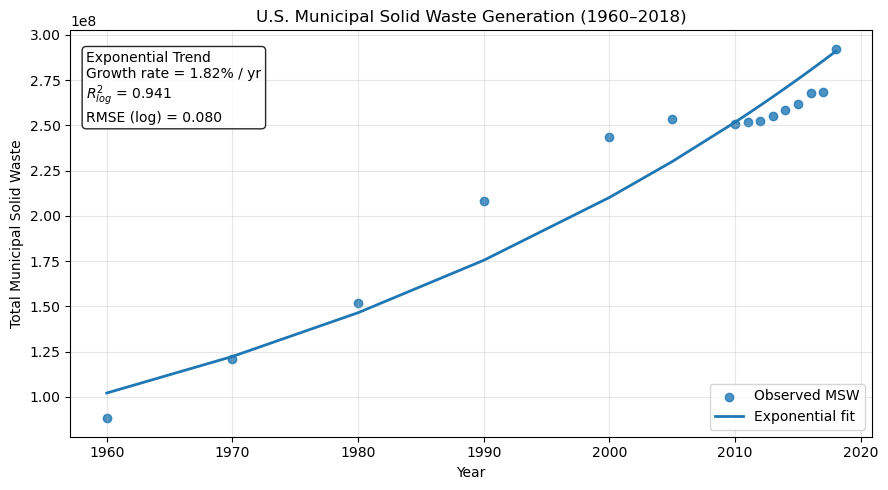

In [30]:
# ------------------------------------------------------------
# Exponential Fit + Key Statistics
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Load data
df = pd.read_csv("~/Desktop/DESCO Case/Municipal Waste/Total_MSW_1960_2018.csv")
df = df.sort_values("year").reset_index(drop=True)

X = df["year"].values.reshape(-1, 1)
y_log = np.log(df["total_msw_generated"].values)

# Fit log-linear model
model = LinearRegression()
model.fit(X, y_log)

y_log_hat = model.predict(X)

r2 = r2_score(y_log, y_log_hat)
rmse = np.sqrt(mean_squared_error(y_log, y_log_hat))
g = model.coef_[0]

# Fitted values in levels
y_hat = np.exp(model.intercept_ + g * df["year"])

# Plot
plt.figure(figsize=(9, 5))
plt.scatter(df["year"], df["total_msw_generated"], label="Observed MSW", alpha=0.8)
plt.plot(df["year"], y_hat, label="Exponential fit", linewidth=2)

# Annotation text - WRITTEN BY CLAUDE.AI
text = (
    f"Exponential Trend\n"
    f"Growth rate = {100*(np.exp(g)-1):.2f}% / yr\n"
    f"$R^2_{{log}}$ = {r2:.3f}\n"
    f"RMSE (log) = {rmse:.3f}"
)

plt.text(
    0.02, 0.95, text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

plt.xlabel("Year")
plt.ylabel("Total Municipal Solid Waste")
plt.title("U.S. Municipal Solid Waste Generation (1960–2018)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


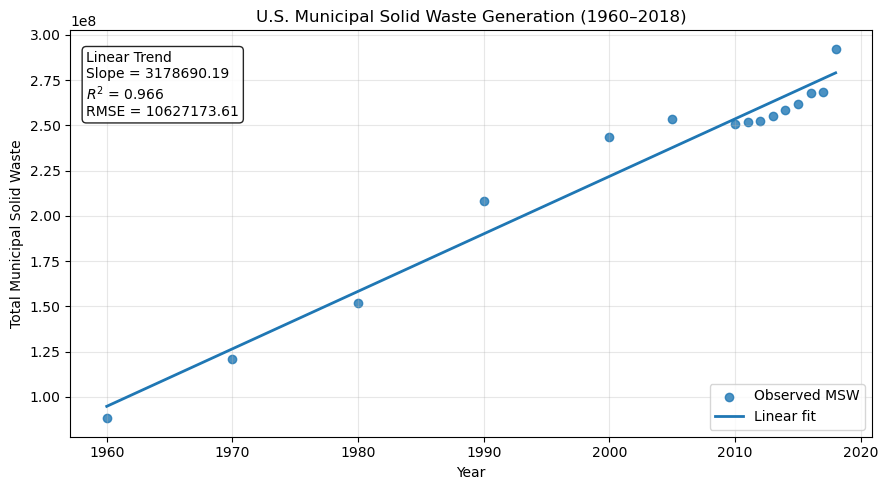

In [29]:

# ------------------------------------------------------------
# Linear Fit + Key Statistics
# ------------------------------------------------------------
y = df["total_msw_generated"].values

# Fit linear model
model = LinearRegression()
model.fit(X, y)

y_hat = model.predict(X)

r2 = r2_score(y, y_hat)
rmse = np.sqrt(mean_squared_error(y, y_hat))
beta = model.coef_[0]

# Plot
plt.figure(figsize=(9, 5))
plt.scatter(df["year"], y, label="Observed MSW", alpha=0.8)
plt.plot(df["year"], y_hat, label="Linear fit", linewidth=2)

# Annotation text - WRITTEN BY CLAUDE.AI
text = (
    f"Linear Trend\n"
    f"Slope = {beta:.2f}\n"
    f"$R^2$ = {r2:.3f}\n"
    f"RMSE = {rmse:.2f}"
)

plt.text(
    0.02, 0.95, text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

plt.xlabel("Year")
plt.ylabel("Total Municipal Solid Waste")
plt.title("U.S. Municipal Solid Waste Generation (1960–2018)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
